# Applied Data Science by IBM
## Capstone project

In this project, we are going to explore, segment, and cluster the neighborhoods in the city of Toronto based on the postalcode and borough information.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

#Install beautifulsoup
#!pip install beautifulsoup4
from bs4 import BeautifulSoup

#Import libraries for Foursquare API
from urllib.request import urlopen
import requests 
from pandas.io.json import json_normalize

#Install pgeocode for getting coordinates
!pip install pgeocode
import pgeocode

#
from sklearn.cluster import KMeans

!pip install folium
import folium

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


### Scraping

In the first part we are going to scrape Toronto postal codes table from Wikipedia page using BeautifulSoup

In [2]:
#get Toronto neighborhood data on Wikipedia
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
page = urlopen(url)
html = page.read().decode("utf-8")
soup = BeautifulSoup(html, "html.parser")

In [3]:
#get postal code table from html
table_content = []
table = soup.find('table')
for row in table.findAll('td'):
    #print(row)
    cell = {}
    #print(row.span.text)
    #Drop postal codes that have no assigned neighborhoods
    if row.span.text == 'Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        rawNeighborh = (row.span.text).split('(')[1]
        #print(rawNeighborh)
        cell['Neighborhood'] = rawNeighborh.strip(')').replace('/',',').replace(')',',').strip(' ')
        table_content.append(cell)
        
#print(table_content)
        

In [4]:
#Create dataframe
toronto_df = pd.DataFrame(table_content)
toronto_df

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park , Harbourfront"
3,M6A,North York,"Lawrence Manor , Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government
...,...,...,...
98,M8X,Etobicoke,"The Kingsway , Montgomery Road , Old Mill North"
99,M4Y,Downtown Toronto,Church and Wellesley
100,M7Y,East TorontoBusiness reply mail Processing Cen...,Enclave of M4L
101,M8Y,Etobicoke,"Old Mill South , King's Mill Park , Sunnylea ,..."


In [5]:
#Clean up Borough data
toronto_df['Borough'] = toronto_df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})
toronto_df

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park , Harbourfront"
3,M6A,North York,"Lawrence Manor , Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government
...,...,...,...
98,M8X,Etobicoke,"The Kingsway , Montgomery Road , Old Mill North"
99,M4Y,Downtown Toronto,Church and Wellesley
100,M7Y,East Toronto Business,Enclave of M4L
101,M8Y,Etobicoke,"Old Mill South , King's Mill Park , Sunnylea ,..."


In [6]:
#Get data dimentions
toronto_df.shape

(103, 3)

### Geolocation

Now that we have a postal code table, we are going to add coordinates to each postal code using pgeocode

In [7]:
#Get gecoordinates
geolocator = pgeocode.Nominatim('ca')

for cell in zip(toronto_df['PostalCode']):
    postal_code = cell[0]
    location = geolocator.query_postal_code(postal_code)
    #print(postal_code, location.latitude, location.longitude)
    toronto_df.loc[toronto_df['PostalCode'] == postal_code, "Latitude"] = location.latitude
    toronto_df.loc[toronto_df['PostalCode'] == postal_code, "Longitude"] = location.longitude

toronto_df.head(10)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.7545,-79.3300
1,M4A,North York,Victoria Village,43.7276,-79.3148
2,M5A,Downtown Toronto,"Regent Park , Harbourfront",43.6555,-79.3626
3,M6A,North York,"Lawrence Manor , Lawrence Heights",43.7223,-79.4504
4,M7A,Queen's Park,Ontario Provincial Government,43.6641,-79.3889
5,M9A,Etobicoke,Islington Avenue,43.6662,-79.5282
6,M1B,Scarborough,"Malvern , Rouge",43.8113,-79.1930
7,M3B,North York,"Don Mills,North",43.7450,-79.3590
8,M4B,East York,"Parkview Hill , Woodbine Gardens",43.7063,-79.3094
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.6572,-79.3783


### Exploring neighborhoods using FoursquareAPI

Now we are going to explore each location using FoursquareAPI

In [8]:
# The code was removed by Watson Studio for sharing.

In [9]:
#Function for getting venues
def getNearbyVenues(postalCodes, latitudes, longitudes, radius = 500):
    
    venues_list = []
    for postalCode, lat, lng in zip(postalCodes, latitudes, longitudes):
        #create url
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        #sending a request to FoursquareAPI
        response = requests.get(url).json()['response']

        try:            
            results = response['groups'][0]['items']
            venues_list.append([(
                postalCode,
                lat,
                lng,
                v['venue']['name'],
                v['venue']['location']['lat'],
                v['venue']['location']['lng'],
                v['venue']['categories'][0]['name']) for v in results])
        
            nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
            nearby_venues.columns = ['PostalCode', 
                      'Neighborhood Latitude', 
                      'Neighborhood Longitude', 
                      'Venue', 
                      'Venue Latitude', 
                      'Venue Longitude', 
                      'Venue Category']
        except:
            print("Error with postal code: " + postalCode)
            print(response)
            continue
            
        
    return nearby_venues  



In [10]:
#Getting venues for each postal code
postalCodes = toronto_df['PostalCode']
latitudes = toronto_df['Latitude']
longitudes = toronto_df['Longitude']
radius = 500
toronto_venues = getNearbyVenues(postalCodes, latitudes, longitudes, radius)
toronto_venues.head()

Error with postal code: M7R
{}


,PostalCode,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M3A,43.7545,-79.3300,KFC,43.754387,-79.333021,Fast Food Restaurant
1,M3A,43.7545,-79.3300,Brookbanks Park,43.751976,-79.332140,Park
2,M3A,43.7545,-79.3300,Variety Store,43.751974,-79.333114,Food & Drink Shop
3,M4A,43.7276,-79.3148,Portugril,43.725819,-79.312785,Portuguese Restaurant
4,M4A,43.7276,-79.3148,Victoria Village Arena,43.723481,-79.315635,Hockey Arena


In [11]:
#analyze venues for each postal code
print('There are {} unique categories'.format(len(toronto_venues['Venue Category'].unique())))
toronto_venues_grouped = toronto_venues.groupby("PostalCode").count()
toronto_venues_grouped.head(10)

There are 247 unique categories


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
PostalCode,,,,,,
M1B,1,1,1,1,1,1
M1E,30,30,30,30,30,30
M1G,2,2,2,2,2,2
M1H,1,1,1,1,1,1
M1J,2,2,2,2,2,2
M1K,15,15,15,15,15,15
M1L,12,12,12,12,12,12
M1M,9,9,9,9,9,9
M1N,4,4,4,4,4,4


There are locations which only have one or two venues. We cannot use them for clustering. Lets filter out all postal codes that have less than 5 venues

In [12]:
#lets filter out neighborhoods that have less than 5 venues
codes_min10venues_df = toronto_venues_grouped[toronto_venues_grouped['Venue'] >= 5]
filtered_codes_list = list(codes_min10venues_df.index)
#filtered_codes_list
toronto_venues_filtered = toronto_venues[toronto_venues['PostalCode'].isin(filtered_codes_list)]
toronto_venues_filtered.groupby("PostalCode").count().shape

(67, 6)

In [13]:
#Prepare data for clustering using one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues_filtered[['Venue Category']], prefix = '', prefix_sep = '')

toronto_onehot["PostalCode"] = toronto_venues_filtered['PostalCode']

fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]
toronto_onehot.head(10)

,PostalCode,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
3,M4A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,M4A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,M4A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,M4A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,M4A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,M4A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,M5A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,M5A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,M5A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,M5A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Lets find frequency of particular venue types for each postal code 

In [14]:
#Finding frequency for each venue
toronto_grouped = toronto_onehot.groupby('PostalCode').mean().reset_index()
toronto_grouped.head()

,PostalCode,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,M1E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,M1K,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,M1L,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,M1M,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,M1S,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now lets get five most frequent venue types for each postal code

In [15]:
#Function for sortig venues by frequency of appearance
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [16]:
#Get 5 most common venues in a neighborhood
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['PostalCode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['PostalCode'] = toronto_grouped['PostalCode']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(10)

,PostalCode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,M1E,Pizza Place,Fast Food Restaurant,Restaurant,Bank,Greek Restaurant
1,M1K,Coffee Shop,Convenience Store,Intersection,Chinese Restaurant,Bank
2,M1L,Bakery,Intersection,Bus Line,Coffee Shop,Bus Station
3,M1M,Ice Cream Shop,Gift Shop,Bistro,Pharmacy,Bank
4,M1S,Breakfast Spot,Latin American Restaurant,Skating Rink,Shanghai Restaurant,Newsagent
5,M1T,Fast Food Restaurant,Pizza Place,Italian Restaurant,Fried Chicken Joint,Bank
6,M1W,Fast Food Restaurant,Noodle House,Sandwich Place,Supermarket,Furniture / Home Store
7,M2J,Clothing Store,Fast Food Restaurant,Restaurant,Coffee Shop,Japanese Restaurant
8,M2N,Coffee Shop,Ramen Restaurant,Japanese Restaurant,Pizza Place,Sushi Restaurant
9,M2R,Coffee Shop,Park,Bookstore,Baby Store,Locksmith


### K-means clustering

Finally, we are going to use k-means clustering to analyze neighborhoods of Toronto

Text(0, 0.5, 'inertia')

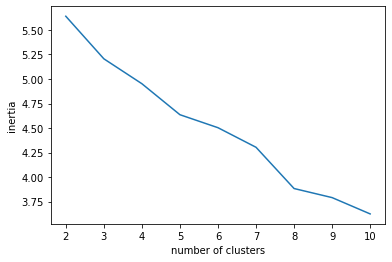

In [17]:
#Clustering
toronto_grouped_clustering = toronto_grouped.drop('PostalCode', 1)

kMaxClusters = 11
inertia = []

# define the best number of clusters
for kclusters in range(2, kMaxClusters):
    #print(kclusters)
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)
    inertia.append(kmeans.inertia_)
    
plt.plot(range(2, kMaxClusters), inertia)
plt.xlabel('number of clusters')
plt.ylabel('inertia')

Lets analyze efficiency of clustering using inertia plot. It looks that there are two elbows at number of clusters 5 and 8. Lets use 5 clusters for simplicity 

In [18]:
#Perform clustering with 5 centroids
kmeans = KMeans(n_clusters=5, random_state=0).fit(toronto_grouped_clustering)
# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 3, 0, 0, 0, 0, 3], dtype=int32)

In [19]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
#neighborhoods_venues_sorted
toronto_merged = toronto_df

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('PostalCode'), on = 'PostalCode')
toronto_merged = toronto_merged.dropna()
toronto_merged.head()


,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,M4A,North York,Victoria Village,43.7276,-79.3148,0.0,Hockey Arena,Park,Coffee Shop,Portuguese Restaurant,Intersection
2,M5A,Downtown Toronto,"Regent Park , Harbourfront",43.6555,-79.3626,0.0,Coffee Shop,Restaurant,Italian Restaurant,Playground,Sushi Restaurant
3,M6A,North York,"Lawrence Manor , Lawrence Heights",43.7223,-79.4504,0.0,Clothing Store,Coffee Shop,Shoe Store,Sushi Restaurant,Restaurant
4,M7A,Queen's Park,Ontario Provincial Government,43.6641,-79.3889,0.0,Gym,Sushi Restaurant,Burrito Place,Music Venue,Theater
5,M9A,Etobicoke,Islington Avenue,43.6662,-79.5282,3.0,Pharmacy,Grocery Store,Skating Rink,Bank,Home Service


Now lets visualize our clusters on the map of Toronto!

In [20]:
latitude = 43.651070
longitude = -79.347015

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters